In [8]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

dataset=pd.read_csv("/home/garvitarora/Garvit/programs/neural_networks/mnsit_train.csv")

x = dataset.iloc[:, 1:785].values
y = dataset.iloc[:, 0].values

y_train=np.transpose(to_categorical(y))

y=y[np.newaxis,:]

x_train=x
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_train=np.transpose(x_train)



test_dataset=pd.read_csv("/home/garvitarora/Garvit/programs/neural_networks/mnist_test.csv")

a=test_dataset.iloc[:,1:785].values
b=test_dataset.iloc[:,0].values

test_y=np.transpose(to_categorical(b))

test_x=np.transpose(a)

test_labels=b[np.newaxis,:]
print(x_train.shape)

print(test_x.shape)
print(test_y.shape)
print(test_labels.shape)


(784, 42000)
(784, 9999)
(10, 9999)
(1, 9999)


Accuracy in epoch 0 is 11.05 percentage
Accuracy in epoch 1 is 9.4 percentage
Accuracy in epoch 2 is 8.311904761904762 percentage
Accuracy in epoch 3 is 7.997619047619048 percentage
Accuracy in epoch 4 is 8.5 percentage
Accuracy in epoch 5 is 11.823809523809524 percentage
Accuracy in epoch 6 is 14.46904761904762 percentage
Accuracy in epoch 7 is 15.85952380952381 percentage
Accuracy in epoch 8 is 16.323809523809523 percentage
Accuracy in epoch 9 is 16.442857142857143 percentage
Accuracy in epoch 10 is 16.597619047619048 percentage
Accuracy in epoch 11 is 16.792857142857144 percentage
Accuracy in epoch 12 is 17.06190476190476 percentage
Accuracy in epoch 13 is 17.349999999999998 percentage
Accuracy in epoch 14 is 17.7 percentage
Accuracy in epoch 15 is 18.085714285714285 percentage
Accuracy in epoch 16 is 18.409523809523808 percentage
Accuracy in epoch 17 is 18.76904761904762 percentage
Accuracy in epoch 18 is 19.20952380952381 percentage
Accuracy in epoch 19 is 19.669047619047618 perce

<ipython-input-12-70b552581485>:62: RuntimeWarning: overflow encountered in exp
  y=1/(1+np.exp(-x) )


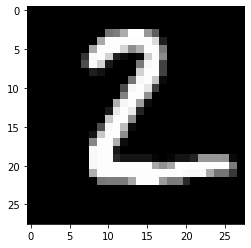

Actually it is 2 predicted is 2


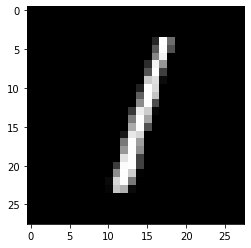

Actually it is 1 predicted is 1


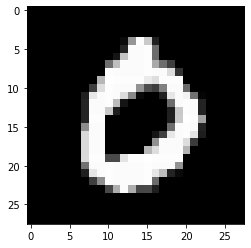

Actually it is 0 predicted is 0


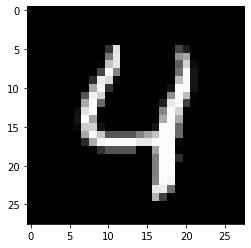

Actually it is 4 predicted is 4


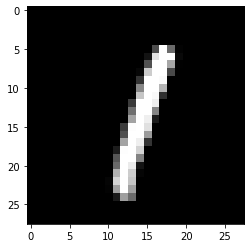

Actually it is 1 predicted is 1


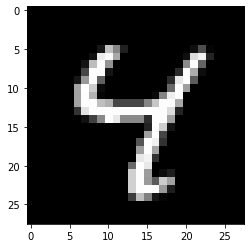

Actually it is 4 predicted is 8


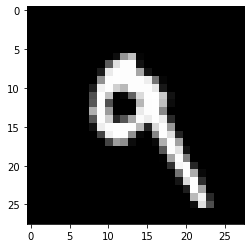

Actually it is 9 predicted is 4


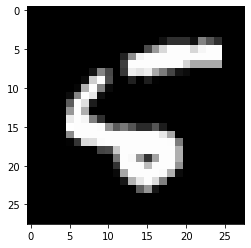

Actually it is 5 predicted is 4


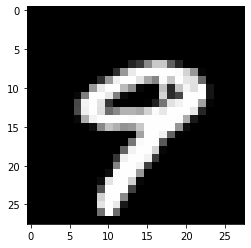

Actually it is 9 predicted is 9


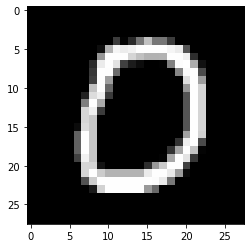

Actually it is 0 predicted is 5


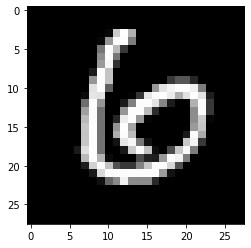

Actually it is 6 predicted is 8


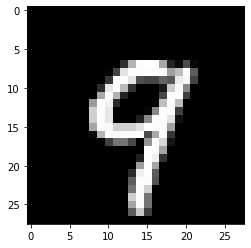

Actually it is 9 predicted is 9


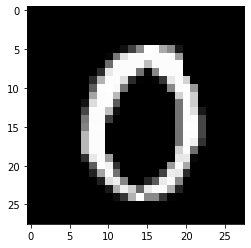

Actually it is 0 predicted is 0


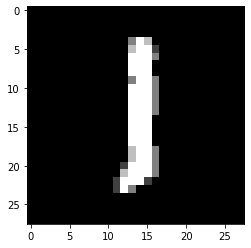

Actually it is 1 predicted is 8


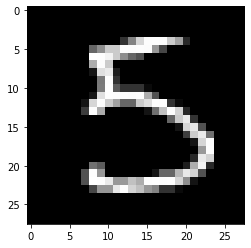

Actually it is 5 predicted is 5


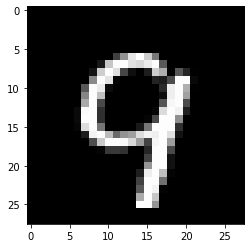

Actually it is 9 predicted is 9


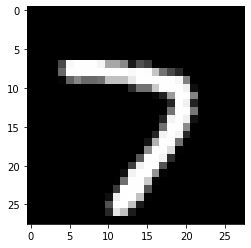

Actually it is 7 predicted is 7


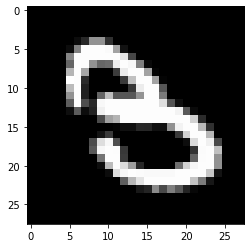

Actually it is 3 predicted is 3


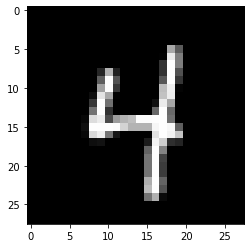

Actually it is 4 predicted is 9


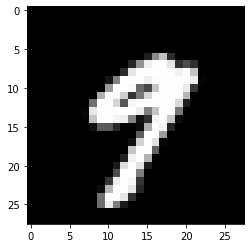

Actually it is 9 predicted is 9


In [12]:
class ann:
    def __init__(self,train,train_result,training_label,test,test_result,testing_label,epoches,alpha,hidden_layers,l):  
        self.train=train
        self.train_result=train_result
        self.training_label=training_label
        self.test=test 
        self.test_result=test_result
        self.testing_label=testing_label
        self.epoches=epoches
        self.alpha=alpha
        self.l=l          # activation function between each rows

        self.input_features=np.shape(train)[0] # along the rows 
        self.output_features = np.shape(train_result)[0]
        self.m=np.shape(train)[1]      # along the columns in a row    

        self.layers=[self.input_features]+hidden_layers+[self.output_features]   # contains number of features in each layer including start , hidden and end layers


        weights=[]     
        bias=[]
         
        
        error_wrt_z=[]
        error_wrt_w=[]
        error_wrt_b=[]

        for i in range(len(self.layers)-1): 
            a=np.random.rand (self.layers[i+1],self.layers[i])-0.5
            weights.append(a)

            b=np.random.rand(self.layers[i+1],1)-0.5          # will use broad casting                                              
            bias.append(b) 

            error_wrt_w.append(i)    # how many dw and db will be there , later i's will be updated with dw and db matrices 

            error_wrt_b.append(i)      # there will be number of (layers - 1) matrices for weights,bias,error wrt w,b,z in each forward propagation   

            error_wrt_z.append(i)  
        
        self.weights=weights
        self.bias=bias

       
        self.error_wrt_z= error_wrt_z
        self.error_wrt_w= error_wrt_w
        self.error_wrt_b= error_wrt_b

        self.activations=[]
        self.z=[]

        self.function_derivitive=[self.reluDerivative,self.sigmoid_derivative]  # in middle layers put relu or sigmoid only you cannnot put softmax in middle as you dont know d softmax(z) / d(z)
        self.function=[self.relu,self.sigmoid,self.softmax]  



    def relu(self,x):
        return np.maximum(0.0, x)


    def sigmoid(self , x):
        y=1/(1+np.exp(-x) )                       
        return y
        
    def sigmoid_derivative(self, x):        #  d sigma(z) / d(z) = sigma(z)*(1-sigma(z)) 
        return np.multiply(x,(1-x))         # in this we are finding for all the a's of the matrix 

    def reluDerivative(self,x):
        y=np.copy(x)
        y[y<=0] = 0
        y[y>0] = 1
        return y     

    def softmax (self,x):
        e=np.exp(x)
        return e/(np.sum(e,axis=0))  


    def forward_propogate(self,data): # we are using forward prop on training as well as testing data so 
        self.activations.clear()   #  with each epoch our w will be updated as dw db dz will be updated so we will be getting new activations as well as z  after each eppoch
        self.z.clear()
        self.z.append(data)
        self.activations.append(data)        ### note z and a will contain all the layers from  1st given layer at indeex 0 to the last output predicted layer 
      
        for i in range (len(self.layers)-1):
            self.z.append(np.add (np.dot(self.weights[i],self.activations[i]) ,self.bias[i]))
        
           # self.z.append(np.add( np.dot( self.weights[i],self.activations[i] ) ,np.repeat(self.bias[i],self.m,axis=1)) )    
            self.activations.append(self.function[self.l[i]](self.z[i+1]  ) )  



    def backward_propogation(self):  # we dont know d softmax(z) / d (z) so we are not using dz formula for last layer 
        self.error_wrt_z[len(self.layers)-2]=np.subtract(self.activations[len(self.layers)-1] , self.train_result )
        for i in reversed(range(len(self.layers) - 1)):
            self.error_wrt_w[i] = 1/self.m*(np.dot((self.error_wrt_z[i]),np.transpose(self.activations[i])))  
            
            self.error_wrt_b[i]=1/self.m *(np.sum(self.error_wrt_z[i] , axis=1 , keepdims=True))

            if i>=1:
                    self.error_wrt_z[i-1]=np.multiply (  np.dot ( np.transpose (self.weights[i]) , self.error_wrt_z[i] )  , self.function_derivitive[ self.l[i-1] ] ( self.function[ self.l[i-1] ]   (self.z[i]) ) )
            else:
                continue

    def training(self):
        for i in range(self.epoches):
            self.forward_propogate(data=self.train)
            final_prediction=self.predict()
            accuracy_percentage=self.accuracy(final_prediction,actual_result=self.training_label)
            print("Accuracy in epoch {} is {} percentage".format(i,accuracy_percentage))
            self.backward_propogation()
            for j in range(len (self.layers)-1):
                self.weights[j]=np.subtract(self.weights[j],self.alpha*self.error_wrt_w[j])
                
                self.bias[j]=np.subtract(self.bias[j],self.alpha*self.error_wrt_b[j])
    
     
    def predict(self):                   
        return (np.argmax(self.activations[-1], axis=0)[np.newaxis,:])        
     
    def accuracy(self,final_prediction,actual_result):
        accuracy_per = (np.sum(actual_result ==final_prediction) / (actual_result).shape[1] ) * 100
        return accuracy_per

    def testing(self):
      self.forward_propogate(data=self.test)
      final_prediction=self.predict()  # now activation layers are for testing data after running this function so we are predicting on testing data only
      accuracy_perct=self.accuracy(final_prediction=final_prediction,actual_result=self.testing_label)
      
      return  accuracy_perct,final_prediction

    def draw(self,indexes,a):    # Run after running testing so you have the predictions saved for your testing data  ****its only for testing data ****
      for i in range (indexes):
        pixel=a[i,np.newaxis].reshape((28,28))
        plt.gray()
        plt.imshow(pixel, interpolation='nearest')
        plt.show()

        label=self.testing_label[0,i]
        prediction=self.testing()[1][0,i]

        print("Actually it is {} predicted is {}".format(label,prediction))

        


model=ann (train=x_train,train_result=y_train,training_label=y,test=test_x,test_result=test_y,testing_label=test_labels,epoches=500,alpha=0.3,hidden_layers=[50,20,25,10],l=[1,0,1,0,2])
model.training()

test_accuracy=model.testing()[0]
print("test accuracy is {} ".format(test_accuracy))

model.draw(indexes=20,a=a)



